**Assignment 1 Task 1: KNN Regressor**  
**Student ID = 31237223**  
**Name = Yee Darren Jer Shien**

**Question 1.1: KNN Regressor**

**1.1 Preprocess Diabetes and California Housing Data**

In [232]:
from sklearn.datasets import load_diabetes, fetch_california_housing

diabetes = load_diabetes()
diabetes.data.shape, diabetes.target.shape, diabetes.feature_names
california_housing = fetch_california_housing()

In [233]:
import numpy as np

# Splits data set according to method used in lab
def train_test_split(x, y, train_size=0.6, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    x_train = x[idx_train]
    y_train = y[idx_train]
    x_test = x[idx_test]
    y_test = y[idx_test]
    return x_train, x_test, y_train, y_test
    

x_train_diabetes, x_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes.data, diabetes.target, train_size=0.6, random_state=1)
x_train_cali, x_test_cali, y_train_cali, y_test_cali = train_test_split(california_housing.data, california_housing.target, train_size=0.6, random_state=1)

**1.1 KNN Regressor Method**

In [234]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
from scipy.stats import pmean
from sklearn.metrics import mean_squared_error 


class KnnRegressor(BaseEstimator):
    def __init__(self,k):
        self.k = k
        
    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self
    
    # Predict method adapted from lab, we take the mean of each neighbouring values to compute our current prediction value
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = pmean(neighbour_labels, axis=1, keepdims=False, p = 1)
        return m

**Question 1.2: Training using Diabetes dataset**

In [235]:
knn1 = KnnRegressor(3)
knn1.fit(x_train_diabetes,y_train_diabetes)
y_hat_test_diabetes = knn1.predict(x_test_diabetes)

**Question 1.2: Training using California housing dataset**

In [236]:
knn2 = KnnRegressor(3)
knn2.fit(x_train_cali,y_train_cali)
y_hat_test_cali = knn2.predict(x_test_cali)

**Question 1.2: Error Rate for Training and Test Error Calculation**

In [237]:
from sklearn.metrics import mean_squared_error 
import math
def error_rate(y, y_hat):
    error = mean_squared_error(y,y_hat)
    return math.sqrt(error)

**Question 1.2: Error Rate of Diabetes dataset**

In [238]:
y_hat_train_diabetes = knn1.predict(x_train_diabetes)
error_rate(y_train_diabetes, y_hat_train_diabetes), error_rate(y_test_diabetes, y_hat_test_diabetes)

(48.50558333074415, 65.71185841590591)

**Question 1.2: Error Rate of California Housing dataset**

In [239]:
y_hat_train_cali = knn2.predict(x_train_cali)
error_rate(y_train_cali, y_hat_train_cali), error_rate(y_test_cali, y_hat_test_cali)

(0.7560985377778375, 1.121240738220602)

**Question 1.2: Default Bootstrap Splitter CV method adapted from lab, used for testing KNN Regressor Model**

In [240]:
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

class BootstrapSplitter:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            N = len(x)
            N_train = round(N*self.train_size)
            train_idx = self.RNG.choice(N, N_train, replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

**Question 1.2: Evaluation method adapted from lab, used to evaluate performance of KNN Regressor Diabetes Model**

In [241]:
from sklearn.model_selection import cross_validate

def evaluation(max_k, cv, data, target):
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))
    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(knn,data,target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
        test_results[:, k-1] = cv_res['test_score']
        train_results[:, k-1] = cv_res['train_score']

    return train_results, test_results

In [242]:
import matplotlib.pyplot as plt

def plot (max_k,train_results,test_results):
    ks = np.arange(1, max_k+1)
    _, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
    z = (reps**0.5)/1.96
    axs[0].errorbar(ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
    axs[0].errorbar(ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
    axs[0].legend()
    axs[0].set_xlabel('$k$')
    axs[0].set_ylabel('error rate')
    axs[1].errorbar(1/ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
    axs[1].errorbar(1/ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
    axs[1].set_xscale('log')
    axs[1].set_xlabel('$1/k$')
    plt.show()

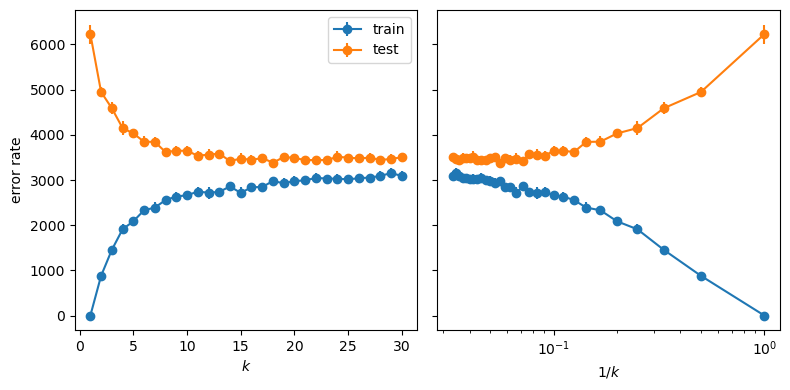

In [243]:
reps=25
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=BootstrapSplitter(reps, 0.6, random_state=0), data = diabetes.data, target = diabetes.target)
plot (max_k,train_results,test_results)

**Question 1.2: Evaluation for KNN Regressor California Housing Model**

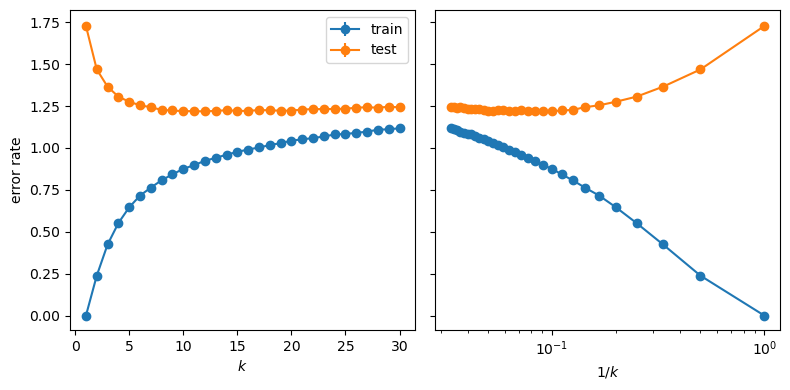

In [244]:
reps=25
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=BootstrapSplitter(reps, 0.6, random_state=0), data = california_housing.data, target = california_housing.target)
plot (max_k,train_results,test_results)

**Question 1.2 Justification**

From both graphs, we can see that our model performs as intended with testing error starting high and training error starting low, before both converging to an optimal level that balances between model's performance on seen and unseen data

**Question 2.1: L Fold Cross Validation Model**

In [245]:
class LFold:
    def __init__(self, k, random_state=None): # ADD PARAMETERS AS REQUIRED
        self.k = k
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.k
    
    def split(self, x, y=None, groups=None):
        # size per fold
        per_fold = len(x) // self.k
        # creates the array contaning [0..len(x)-1] which represents all indices available for selection
        indices_arr = np.arange(len(x))
        np.random.shuffle(indices_arr)
        for i in range (self.k):
            # slice the test idx based on the current fold
            test_idx = indices_arr [i*per_fold : i*per_fold + per_fold]
            # take every index before the current fold
            head = indices_arr [:i*per_fold]
            # take every index after the current fold
            tail = indices_arr [i*per_fold + per_fold:] 
            # concatenate the leftover array into our train idx array
            train_idx = np.concatenate((head,tail))
            yield train_idx, test_idx


**Question 2.2 Evaluation Model for L Fold Cross Validation Model**

In [246]:
from sklearn.model_selection import cross_validate

def evaluation_l_fold(max_k, cv,data,target):
    
    r = cv.get_n_splits()
    test_mean = np.zeros(max_k)
    test_std = np.zeros(max_k)
    test_con = np.zeros(max_k)
    train_mean = np.zeros(max_k)
    train_std = np.zeros(max_k)
    train_con = np.zeros(max_k)
    
    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        current_fold_test_score = []
        current_fold_train_score = []
        test_scores = []
        train_scores = []
        
        for train_index, test_index in cv.split(data):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index],target[test_index]

            knn.fit(X_train, y_train)
            y_train_pred = knn.predict(X_train)
            y_test_pred = knn.predict(X_test)

            train_scores.append(mean_squared_error(y_train, y_train_pred))
            test_scores.append(mean_squared_error(y_test, y_test_pred))
            
        test_mean[k - 1] = np.mean(test_scores)
        test_std[k - 1] = np.std(test_scores)
        test_con[k - 1] = (1.96 * test_std[k - 1]) / (np.sqrt(r))

        train_mean[k - 1] = np.mean(train_scores)
        train_std[k - 1] = np.std(train_scores)
        train_con[k - 1] = (1.96 * train_std[k - 1]) / (np.sqrt(r))
        
    return test_mean, test_std , test_con, train_mean, train_std, train_con

In [247]:
def l_fold_plot (max_k, plot, test_mean, test_std , test_con, train_mean, train_std, train_con):
    
    if plot == 1:
        plt.errorbar(range(1, max_k + 1), train_mean, yerr=train_std, label='Train')
        plt.errorbar(range(1, max_k + 1), test_mean, yerr=test_std, label='Test')
        plt.xlabel('Value of k')
        plt.ylabel('Mean Squared Error with std deviation error bar')
        plt.title('Mean Squared Error vs k')
        plt.legend()
        plt.show()
    
    elif plot == 2:
        plt.errorbar(range(1, max_k + 1), train_std, label='Train')
        plt.errorbar(range(1, max_k + 1), test_std, label='Test')
        plt.xlabel('Value of k')
        plt.ylabel('Standard Deviation')
        plt.title('Standard Deviation vs k')
        plt.legend()
        plt.show()
        
    else:
        plt.errorbar(range(1, max_k + 1), train_mean, yerr=train_con, label='Train')
        plt.errorbar(range(1, max_k + 1), test_mean, yerr=test_con, label='Test')
        plt.xlabel('Value of k')
        plt.ylabel('Mean Squared Error with confidence interval error bar')
        plt.title('Mean Squared Error vs k')
        plt.legend()
        plt.show()

**Question 2.2 Running L Fold evaluation on Diabetes data set**

In [248]:
max_k = 50
test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes= evaluation_l_fold(max_k=max_k, cv=LFold(5, random_state=0),data = diabetes.data,target = diabetes.target)

**Question 2.2 Mean MSE vs k plot for diabetes data**

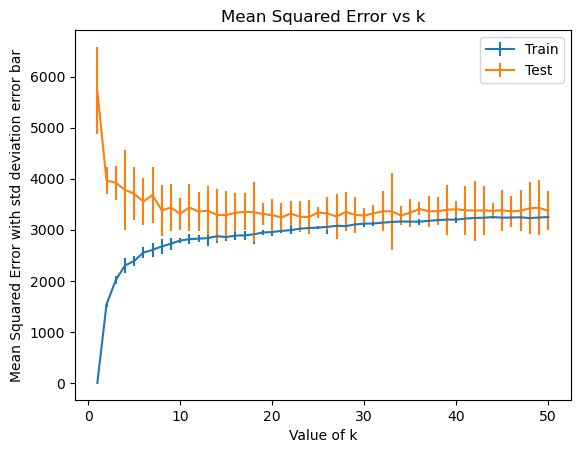

In [249]:
l_fold_plot (max_k, 1, test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes)

**Question 2.2 Standard Deviation vs k plot for diabetes data**

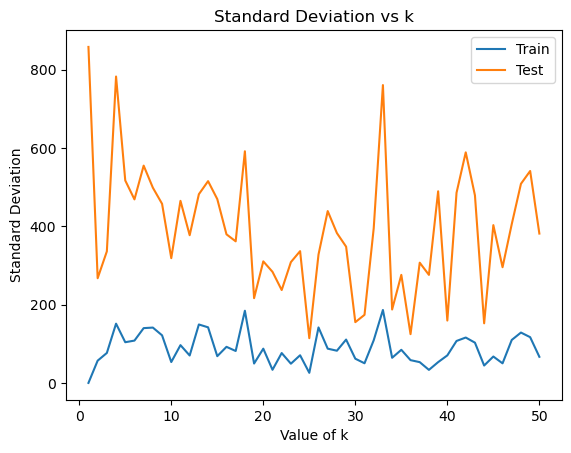

In [250]:
l_fold_plot (max_k, 2, test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes)

**Question 2.2 Reporting best K according to testing performance**

In [251]:
best_test_diabetes = np.argmin(test_mean_diabetes)
print ("Best K for Diabetes data set according to testing performance = ", best_test_diabetes + 1)

Best K for Diabetes data set according to testing performance =  21


**Question 2.2 Running L Fold evaluation on California Housing data set**

In [252]:
max_k = 50
test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch= evaluation_l_fold(max_k=max_k, cv=LFold(5, random_state=0),data = california_housing.data,target = california_housing.target)

**Question 2.2 Mean MSE vs k plot for California Housing data**

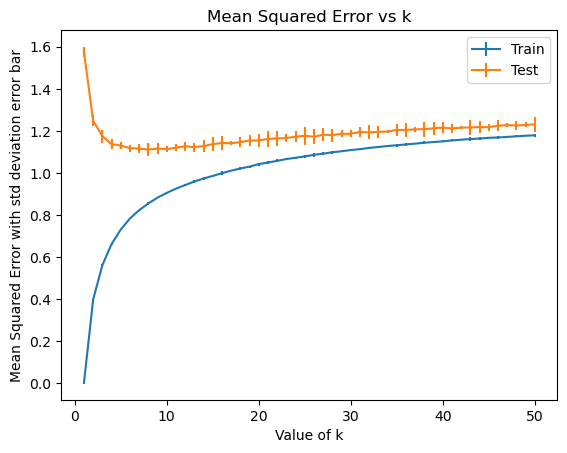

In [253]:
l_fold_plot (max_k, 1, test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch)

**Question 2.2 Standard Deviation vs k plot for California Housing data**

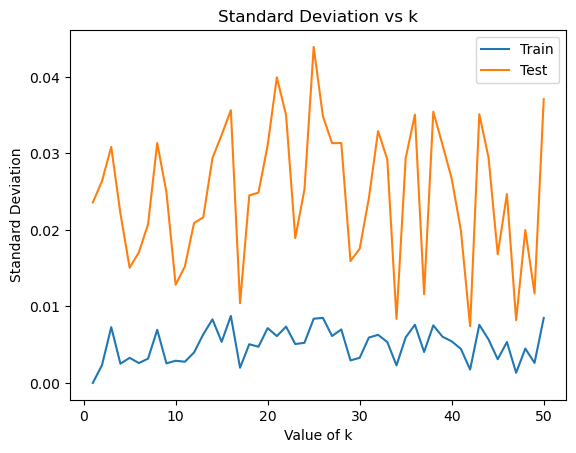

In [254]:
l_fold_plot (max_k, 2, test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch)

**Question 2.2 Reporting best K according to testing performance**

In [255]:
best_test_ch = np.argmin(test_mean_ch)
print ("Best K for California Housing data set according to testing performance = ", best_test_ch + 1)

Best K for California Housing data set according to testing performance =  8


**Question 2.3 MSE plot against K using confidence interval error bar with L = 5 for Diabetes data set**

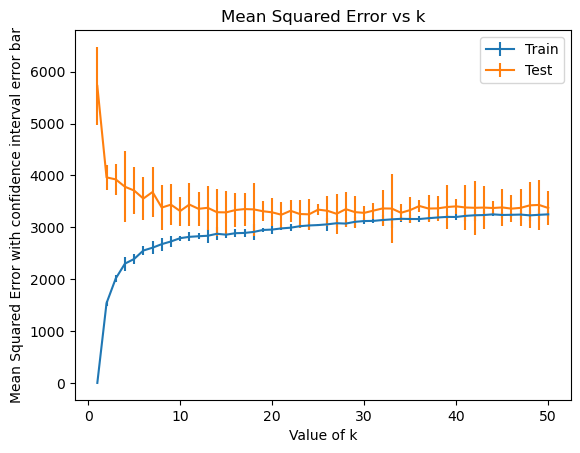

In [256]:
l_fold_plot (max_k, 3, test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes)

**Question 2.3 MSE plot against K using confidence interval error bar with L = 5 for California Housing data set**

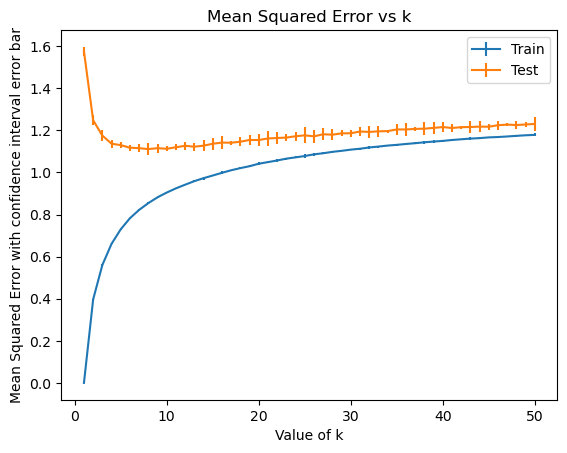

In [257]:
l_fold_plot (max_k, 3, test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch)

**Question 2.3 Running both datasets with different L value**

In [258]:
max_k = 50
fold = 20
test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes= evaluation_l_fold(max_k=max_k, cv=LFold(fold, random_state=0),data = diabetes.data,target = diabetes.target)

In [259]:
test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch= evaluation_l_fold(max_k=max_k, cv=LFold(fold, random_state=0),data = california_housing.data,target = california_housing.target)

**Question 2.3 MSE plot against K using confidence interval error bar with L = 10 for Diabetes data set**

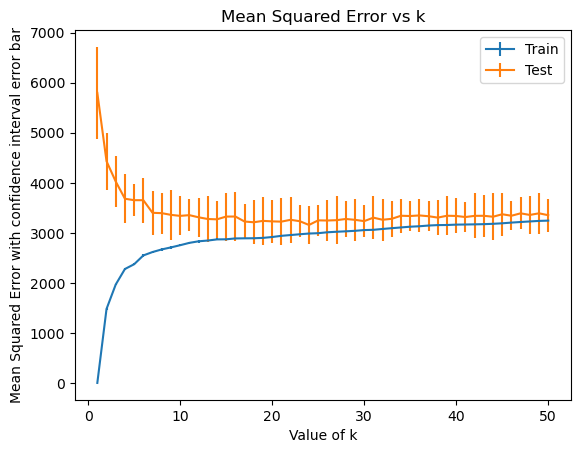

In [260]:
l_fold_plot (max_k, 3, test_mean_diabetes, test_std_diabetes , test_con_diabetes, train_mean_diabetes, train_std_diabetes, train_con_diabetes)

**Question 2.3 MSE plot against K using confidence interval error bar with L = 10 for California Housing data set**

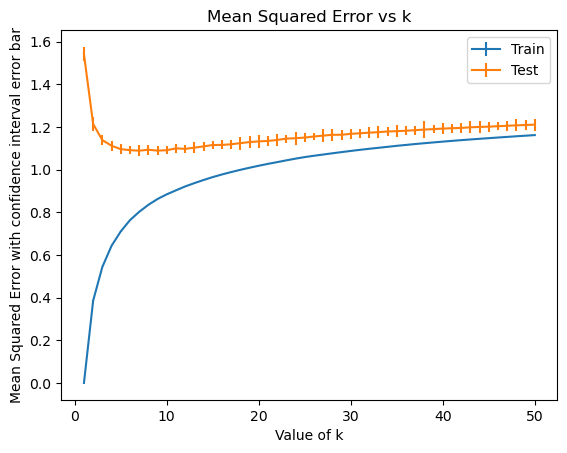

In [261]:
l_fold_plot (max_k, 3, test_mean_ch, test_std_ch , test_con_ch, train_mean_ch, train_std_ch, train_con_ch)

**Question 2.3 Justification**

**Effects of parameter K**  
The parameter K is extremely important for our KNN regressor as it decides how many neighbours should we base our predictions on. As we can see from the graphs, the model starts off overfitting for both datasets due to their low initial mean squared error values for training but high values for testing. This is due to the phenomenon that the model captures more noise instead of learning the underlying pattern which means that it fails to generalise well. However, as we increase the amount of points within the neighbourhood, we start to see testing error going down and training error going up instead, which shows that the model is slowly capturing relavant underlying pattern to predict unseen data. However, for both datasets, we can see that once K gets to around 20-30, the model becomes too simple due to the large number of points within the neighbourhood which causes both testing and training error to either stagnate or rise because the model is unable to capture relevant information.

**Effects of L**    
We performed the same evaluation with different L values on both datasets and in both cases, we are able to see the effects of the increased number of fold by observing the confidence intervals. The confidence intervals for our training error seemingly decreases significantly which seems to indicate that the increased folds are helping the CV process by decreasing variability different portions of the data are being used which allows for a more stable estimation of training performance

**Question 3 KNN Regressor with nested CV**

In [262]:
from sklearn.base import BaseEstimator

class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
    # YOUR CODE HERE
        self.ks = ks
        self.cv = cv
        self.inner_best_k =[]
        self.outer_best_k = []
        
    def fit(self, x, y):
    # YOUR CODE HERE
        self.k = 0 
        r = self.cv.get_n_splits()
        current_best_k = 0
        current = 0
        for idx_train, idx_test in self.cv.split(x):
            best_test = math.inf
            current_best_k = 0
            # for every k, loop every fold combination of this current fold
            for i in range (len(self.ks)):
                knn = KnnRegressor(self.ks[i])
                # inner cross validation
                for idx_train_inner, idx_val in self.cv.split(x[idx_train]):
                    current_fold_test = []
                    current_fold_train = []
                    cv_res = cross_validate(knn, x[idx_train_inner], y[idx_train_inner], cv=self.cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
                    current_fold_train.append(cv_res['train_score'])
                    current_fold_test.append(cv_res['test_score'])
                current_fold_train_score = np.mean(current_fold_train)
                current_fold_test_score = np.mean(current_fold_test)
                if current_fold_test_score < best_test:
                    current_best_k = self.ks[i]
                    best_test = current_fold_test_score
            self.inner_best_k.append(current_best_k)
            current += 1
            
            # Outer cross validation for outer folds which includes the training sets
            best_outer_k = 0
            best_outer_score = math.inf
            for k in self.ks:
                knn = KnnRegressor(k)
                knn.fit(x[idx_train], y[idx_train])
                y_pred = knn.predict(x[idx_test])
                outer_score = mean_squared_error(y[idx_test], y_pred)
                if outer_score < best_outer_score:
                    best_outer_score = outer_score
                    best_outer_k = k
            self.outer_best_k.append(best_outer_k)
        self.k = math.floor(np.mean(self.inner_best_k))
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self
                
                
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = pmean(neighbour_labels, axis=1, keepdims=False, p = 1)
        return m

In [263]:
knn_cv = KnnRegressorCV()
knn_cv.fit(x_train_diabetes,y_train_diabetes)
y_hat_test_diabetes = knn_cv.predict(x_test_diabetes)
y_hat_train_diabetes = knn_cv.predict(x_train_diabetes)
error_rate(y_train_diabetes, y_hat_train_diabetes), error_rate(y_test_diabetes, y_hat_test_diabetes)

(57.82457620597039, 54.32521156685629)

In [264]:
knn_cv2 = KnnRegressorCV()
knn_cv2.fit(x_train_cali,y_train_cali)
y_hat_test_cali = knn_cv2.predict(x_test_cali)
y_hat_train_cali = knn_cv2.predict(x_train_cali)
error_rate(y_train_cali, y_hat_train_cali), error_rate(y_test_cali, y_hat_test_cali)

(0.9599509799467973, 1.0894768645457906)

**Question 3.2 Displaying the inner and outer CV across both datasets**

In [265]:
print ("KNN Regressor Diabetes Inner CV Best K = ", np.mean(knn_cv.inner_best_k))
print ("KNN Regressor Diabetes Outer CV Best K = ", np.mean(knn_cv.outer_best_k))
print ("KNN Regressor California Housing Inner CV Best K = ", np.mean(knn_cv2.inner_best_k))
print ("KNN Regressor California Housing Outer CV Best K = ", np.mean(knn_cv2.outer_best_k))

KNN Regressor Diabetes Inner CV Best K =  14.2
KNN Regressor Diabetes Outer CV Best K =  12.0
KNN Regressor California Housing Inner CV Best K =  10.0
KNN Regressor California Housing Outer CV Best K =  8.0


**Question 3.2 Justification for inner and outer CV**

For both datasets, we can see that the inner cross validation is consistently able to select an optimal K that is close to the outer cross validation step. This is crucial since the outer cross validation is done with the testing set included. This means that the inner CV is able to find hyperparameters that are close enough for the data to perform well for both training data as well as generalise well on unseen data